In [1]:
from fastai2.basics import *
from fastai2.vision.all import *

import kornia
from mish_cuda import MishCuda

from tqdm.notebook import tqdm
from sklearn.utils import shuffle

import astropy.io.ascii
from astropy.coordinates import SkyCoord
import astropy.units as u

PATH = Path('../..').resolve()

%matplotlib inline

seed = 12345

In [2]:
# reproducability flags
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def root_mean_squared_error(preds, targs):  return torch.sqrt(F.mse_loss(preds.reshape(-1, 1), targs.reshape(-1, 1)))
def slope(p, y): return ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

def summary_stats(preds, trues, mask):
    """Given preds, trues, and some PR conditional mask, 
    output the total number (N), RMSE, slope, std, and offset.
    """    
    return (
        sum(mask), 
        ((preds[mask] - trues[mask])**2).mean()**0.5, 
        slope(preds[mask], trues[mask]),
        (preds[mask] - trues[mask]).std(), 
        (preds[mask].mean() - trues[mask].mean()),
    )


# allow ColReader to look in different `pref` paths if needed
class ModifiedColReader():
    "Read `cols` in `row` with potential `pref` and `suff`"
    def __init__(self, cols, pref='', suff='', label_delim=None):
        store_attr(self, 'suff,label_delim')
        self.pref = str(pref) + os.path.sep if isinstance(pref, Path) else pref
        self.cols = L(cols)

    def _do_one(self, r, c):
        o = r[c] if isinstance(c, int) else r[c] if c=='name' else getattr(r, c)
        if len(self.pref)==0 and len(self.suff)==0 and self.label_delim is None: return o
        if self.label_delim is None and len(o) < 10: return f'{PATH}/images-OC/{o}{self.suff}'
        elif self.label_delim is None and len(o) >= 10: return f'{PATH}/images-nondetections/{o}{self.suff}' 
        else: return o.split(self.label_delim) if len(o)>0 else []

    def __call__(self, o, **kwargs):
        if len(self.cols) == 1: return self._do_one(o, self.cols[0])
        return L(self._do_one(o, c) for c in self.cols)

image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

item_tfms = []
batch_tfms = aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.)+[Normalize.from_stats(*image_stats)]

# Test NIBLES using our PR model

In [36]:
a40 = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})
nd = pd.read_csv(f'{PATH}/results/nondetections/a100-nd_himass_lowz.csv', dtype={'objID': str})

nd['detected'] = False
a40['detected'] = True

a40['objID'] = a40.AGCNr.astype(str)
nd.objID = nd.objID.astype(str)

combined = pd.concat([
    a40[['objID', 'detected']],
    nd[['objID', 'detected']].sample(7399, random_state=seed)
])

In [37]:
nd_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ModifiedColReader(['objID'], pref=(f'{PATH}/images-OC/'), suff='.jpg'),
    get_y=Pipeline([ColReader(['detected'])]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

nd_dls = ImageDataLoaders.from_dblock(nd_dblock, combined, path=PATH, bs=64)

In [38]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=2)

learn = Learner(
    nd_dls, 
    model, 
    opt_func=ranger, 
    loss_func=LabelSmoothingCrossEntropy(eps=0.05), 
    metrics=[accuracy, RocAuc()]
)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


In [39]:
learn = learn.load('fastai2-xresnet34-non_detections_smoothed');

## Get NIBLES detection probabilities

In [40]:
nibles = pd.read_csv(f'{PATH}/data/NIBLES_clean.csv')
nibles = nibles[(nibles.logMstar > 8) & np.isfinite(nibles.logfgas)]

nible_ids = np.array([p.stem for p in list(PATH.glob(pattern='images-nibles_cleaned/*.jpg'))], dtype=int)

nibles.set_index('nibles_id', inplace=True)
nibles.drop([obj for obj in nibles.index if obj not in nible_ids], inplace=True)
nibles.reset_index(inplace=True)
nibles.nibles_id = nibles.nibles_id.astype(str)

In [41]:
%%capture

nibles_p_detection = np.array([to_np(learn.predict(f'{PATH}/images-nibles_cleaned/{fn}.jpg')[2][1]) for fn in nibles.nibles_id])
nibles['p_CNN'] = nibles_p_detection

## Get NIBLES HI/stellar mass predictions

In [42]:
a40 = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, a40, path=PATH, bs=64)

In [43]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)
learn = learn.load('fastai2-xresnet34-a40A-1');

In [44]:
nibles_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['nibles_id'], pref=f'{PATH}/images-nibles_cleaned/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=FuncSplitter(lambda x: False),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

In [45]:
nibles_dls = ImageDataLoaders.from_dblock(nibles_dblock, nibles, path=PATH, bs=1)

nibles_preds, nibles_trues = learn.get_preds(dl=nibles_dls.train)
nibles_preds = to_np(nibles_preds.view(-1))
nibles_trues = to_np(nibles_trues.view(-1))

nibles['fgas_pred'] = nibles_preds
nibles['fgas_true'] = nibles_trues

In [58]:
# nibles.to_csv(f'{PATH}/results/predictions/nibles-v2_trained-on-a40.csv', index='nibles_id')
nibles = pd.read_csv(f'{PATH}/results/predictions/nibles-v2_trained-on-a40.csv', index_col='nibles_id')

In [59]:
print(' p,    N,   RMSE, slope,  std, offset')
for p in [0.0, 0.5, 0.80, 0.9]:
    print([p] + list(map(
                partial(np.round, decimals=3), 
                summary_stats(nibles_preds, nibles_trues, nibles_p_detection > p)))
         )

 p,    N,   RMSE, slope,  std, offset
[0.0, 941, 0.367, 0.836, 0.338, 0.144]
[0.5, 804, 0.354, 0.847, 0.32, 0.15]
[0.8, 693, 0.348, 0.853, 0.314, 0.15]
[0.9, 601, 0.34, 0.864, 0.308, 0.143]


Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

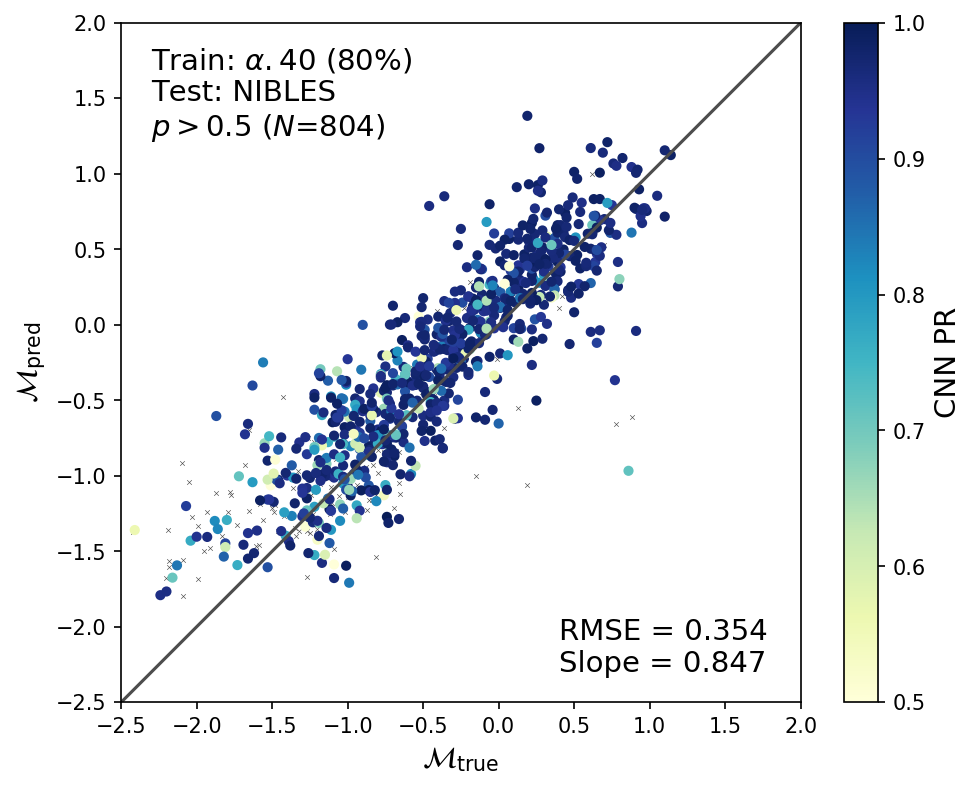

In [86]:
plt.figure(figsize=(7.5, 6), dpi=150)

p = 0.5
N, rmse_nibles_CNN, slope_nibles_CNN, _, _ = summary_stats(nibles.fgas_pred, nibles.fgas_true, nibles.p_CNN > p)

plt.scatter(nibles[nibles.p_CNN <= p].fgas_true, nibles[nibles.p_CNN <= p].fgas_pred, marker='x', lw=0.3, c='0.3', s=5)
sc = plt.scatter(nibles[nibles.p_CNN > p].fgas_true, nibles[nibles.p_CNN > p].fgas_pred, c=nibles[nibles.p_CNN > p].p_CNN, s=15, vmin=0.5, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.25, r'Train: $\alpha.40$ (80%)' + f'\nTest: NIBLES \n$p>{p:.1f}$ ($N$={N})', fontsize=14)
plt.text(0.4, -2.3, f'RMSE = {rmse_nibles_CNN:.3f}' + f'\nSlope = {slope_nibles_CNN:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)


Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

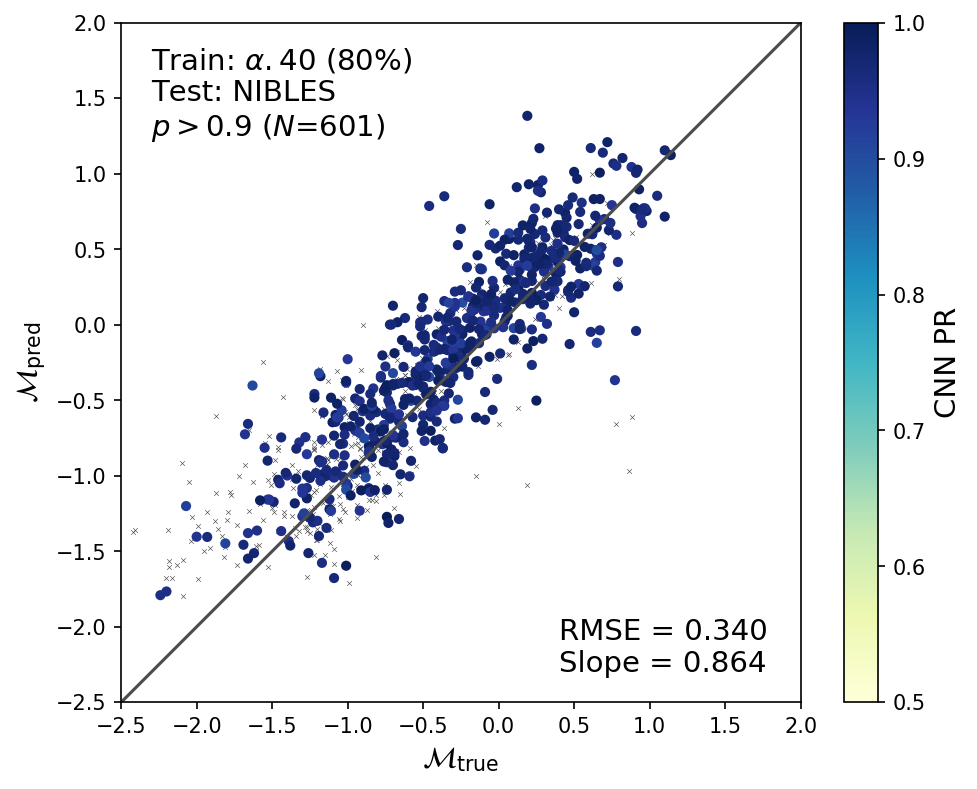

In [87]:
plt.figure(figsize=(7.5, 6), dpi=150)

p = 0.9
N, rmse_nibles_CNN, slope_nibles_CNN, _, _ = summary_stats(nibles.fgas_pred, nibles.fgas_true, nibles.p_CNN > p)

plt.scatter(nibles[nibles.p_CNN <= p].fgas_true, nibles[nibles.p_CNN <= p].fgas_pred, marker='x', lw=0.3, c='0.3', s=5)
sc = plt.scatter(nibles[nibles.p_CNN > p].fgas_true, nibles[nibles.p_CNN > p].fgas_pred, c=nibles[nibles.p_CNN > p].p_CNN, s=15, vmin=0.5, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.25, r'Train: $\alpha.40$ (80%)' + f'\nTest: NIBLES \n$p>{p:.1f}$ ($N$={N})', fontsize=14)
plt.text(0.4, -2.3, f'RMSE = {rmse_nibles_CNN:.3f}' + f'\nSlope = {slope_nibles_CNN:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)


# Comparing $\alpha.40$ self-validation with T17

## Get predictions

In [64]:
a40 = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, a40, path=PATH, bs=64)

In [65]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)
learn = learn.load('fastai2-xresnet34-a40A-1');

In [66]:
a40_preds, a40_trues = learn.get_preds()
a40_preds, a40_trues = to_np(a40_preds).flatten(), to_np(a40_trues).flatten()

In [67]:
# validation
list(map(partial(np.round, decimals=3), summary_stats(a40_preds, a40_trues, np.ones_like(a40_trues, dtype=bool))))

[1479, 0.229, 0.854, 0.227, 0.027]

## Get our predictions on entire $\alpha.40$ sample (including training portion)

In [68]:
a40 = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, a40, path=PATH, bs=64, drop_last=False, shuffle_train=False)

In [69]:
a40_idx = dls.train.items.AGCNr
a40_preds, a40_trues = learn.get_preds(dl=dls.train, reorder=False)
a40_preds, a40_trues = to_np(a40_preds).flatten(), to_np(a40_trues).flatten()

In [70]:
a40_results = pd.DataFrame(
    {
        'fgas_pred': a40_preds,
        'fgas_true': a40_trues
    }, index=dls.train.items.AGCNr.astype(int)
)

In [71]:
# full sample
list(map(partial(np.round, decimals=3), summary_stats(a40_preds, a40_trues, np.ones_like(a40_trues, dtype=bool))))

[7399, 0.234, 0.844, 0.232, 0.03]

## Get T17 results

In [72]:
t17 = astropy.io.ascii.read(f'{PATH}/data/Teimoorinia+17.csv').to_pandas().loc[2:]

t17 = t17.astype(
    {
        'SDSS': np.int64, 'RAJ2000': float, 'DEJ2000': float, 'z': float, 
        'logM*': float, 'logMHI/M*': float, 'Cfgas': float, 'PR': float,
        'sigmafitN': float, 'sigmafit': float, 'sigmafgas': float, 'Sloan': str
    }
)


In [73]:
# get ALFALFA coordinates
a40 = (
    pd.read_csv(f'{PATH}/data/a40.datafile1.csv').join(
        pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), index_col='AGCNr'), 
        on='AGCNr', lsuffix='_left', how='inner'
    ).join(
        a40_results, on='AGCNr', rsuffix='_results', how='inner'
    )
)

len(a40)

7399

In [74]:
a40_coords = SkyCoord(a40.RAdeg_OC, a40.DECdeg_OC, unit=u.deg)
t17_coords = SkyCoord(t17.RAJ2000, t17.DEJ2000, unit=u.deg)

In [75]:
# use conservative 1" cutoff (gets 4938 / 7399)
cutoff = 1 / 3600
idx_t17, idx_a40, _, _ = a40_coords.search_around_sky(t17_coords, cutoff*u.deg)
len(list(idx_a40)), len(set(idx_a40)), len(list(idx_t17)), len(set(idx_t17))

(4938, 4938, 4938, 4938)

In [76]:
t17_x_a40 = t17.iloc[idx_t17]
a40_x_t17 = a40.iloc[idx_a40]

a40_x_t17.reset_index(drop=True, inplace=True)
t17_x_a40.reset_index(inplace=True)

t17_x_a40 = t17_x_a40.rename({'z': 'z_t17', 'logMHI/M*': 'fgas_t17'}, axis=1)

a40_x_t17 = a40_x_t17.join(t17_x_a40, rsuffix='_T17')


In [78]:
# save this
# a40_x_t17.to_csv(f'{PATH}/results/predictions/a40xT17-v2_trained-on-a40.csv', index='AGCNr')
a40_x_t17 = pd.read_csv(f'{PATH}/results/predictions/a40xT17-v2_trained-on-a40.csv', index_col='AGCNr')

In [79]:
# Using T17 cut (Cfgas > 0.5), show my results first, then T17

print('      N,   RMSE, slope,  std, offset')

print(
    'CNN:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(a40_x_t17.fgas_pred, a40_x_t17.fgas_true, a40_x_t17.Cfgas > 0.5)))))
)

print(
    'T17:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(a40_x_t17.fgas_t17, a40_x_t17.fgas_true, a40_x_t17.Cfgas > 0.5)))))
)



      N,   RMSE, slope,  std, offset
CNN:  3452 0.186 0.836 0.185 0.017
T17:  3452 0.246 0.818 0.235 -0.072


In [80]:
# T17: PR > 0.5
print('      N,   RMSE, slope,  std, offset')

print(
    'CNN:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(a40_x_t17.fgas_pred, a40_x_t17.fgas_true, a40_x_t17.PR > 0.5)))))
)

print(
    'T17:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(a40_x_t17.fgas_t17, a40_x_t17.fgas_true, a40_x_t17.PR > 0.5)))))
)



      N,   RMSE, slope,  std, offset
CNN:  3845 0.19 0.844 0.189 0.021
T17:  3845 0.25 0.823 0.241 -0.066


In [81]:
# T17: sigma_fit < 0.1
print('      N,   RMSE, slope,  std, offset')

print(
    'CNN:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(a40_x_t17.fgas_pred, a40_x_t17.fgas_true, a40_x_t17.PR > 0.5)))))
)

print(
    'T17:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(a40_x_t17.fgas_t17, a40_x_t17.fgas_true, a40_x_t17.PR > 0.5)))))
)


      N,   RMSE, slope,  std, offset
CNN:  3845 0.1901 0.8438 0.189 0.0206
T17:  3845 0.2499 0.8225 0.241 -0.066


In [119]:
# no cut at all
print(
    'CNN:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(a40_x_t17.fgas_pred, a40_x_t17.fgas_true, a40_x_t17.PR > -1)))))
)

print(
    'T17:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(a40_x_t17.fgas_t17, a40_x_t17.fgas_true, a40_x_t17.PR > -1)))))
)

CNN:  4938 0.1972 0.8556 0.1955 0.0258
T17:  4938 0.2644 0.8281 0.2573 -0.0613


## Compare to our predictions on entire sample 

### (with Cfgas mask)

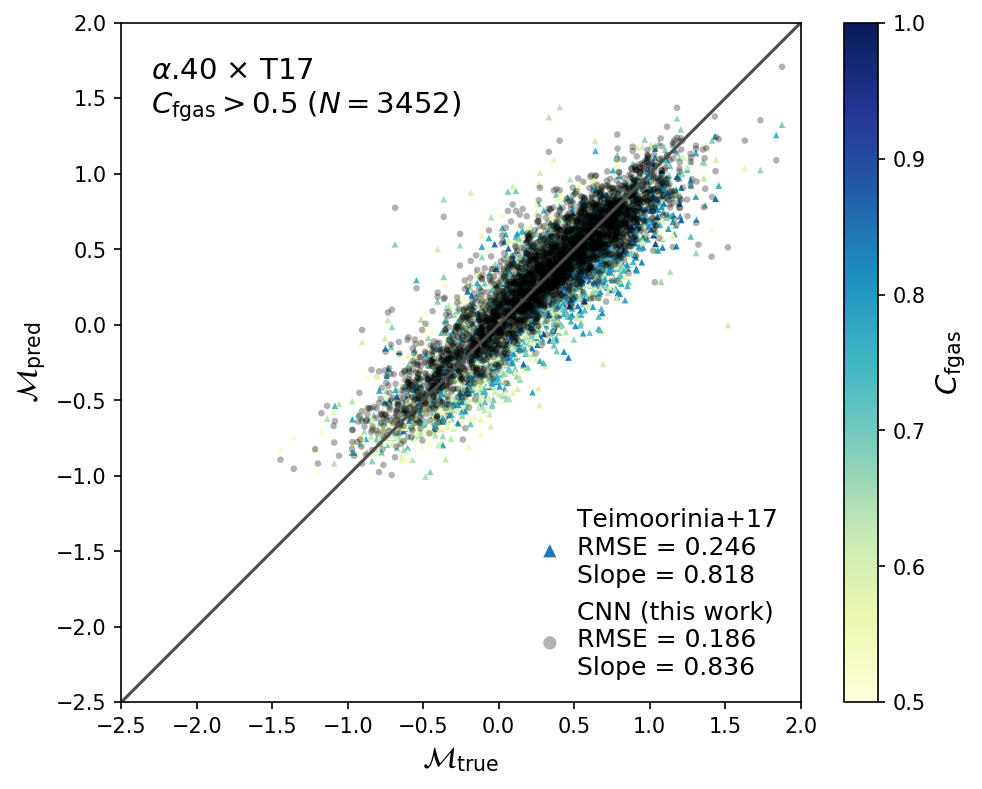

In [156]:
plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
mask = a40_x_t17.Cfgas > 0.5
N, rmse_a40_T17, slope_a40_T17, _, _ = summary_stats(a40_x_t17.fgas_t17, a40_x_t17.fgas_true, mask)
_, rmse_a40_CNN, slope_a40_CNN, _, _ = summary_stats(a40_x_t17.fgas_pred, a40_x_t17.fgas_true, mask)

sc = plt.scatter(a40_x_t17[mask].fgas_true, a40_x_t17[mask].fgas_t17, c=a40_x_t17[mask].Cfgas, edgecolors='none', cmap='YlGnBu', marker='^', s=10, vmin=0.5, vmax=1, label=f'Teimoorinia+17\nRMSE = {rmse_a40_T17:.3f}\nSlope = {slope_a40_T17:.3f}')
plt.scatter(a40_x_t17[mask].fgas_true, a40_x_t17[mask].fgas_pred, c='k', edgecolors='none', alpha=0.3, s=10, label=f'CNN (this work)\nRMSE = {rmse_a40_CNN:.3f}\nSlope = {slope_a40_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'$\alpha$.40 $\times$ T17' '\n' r'$C_{\rm fgas} > 0.5$' f' ($N={N}$)', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=2, handletextpad=0.1)

### (with no PR)

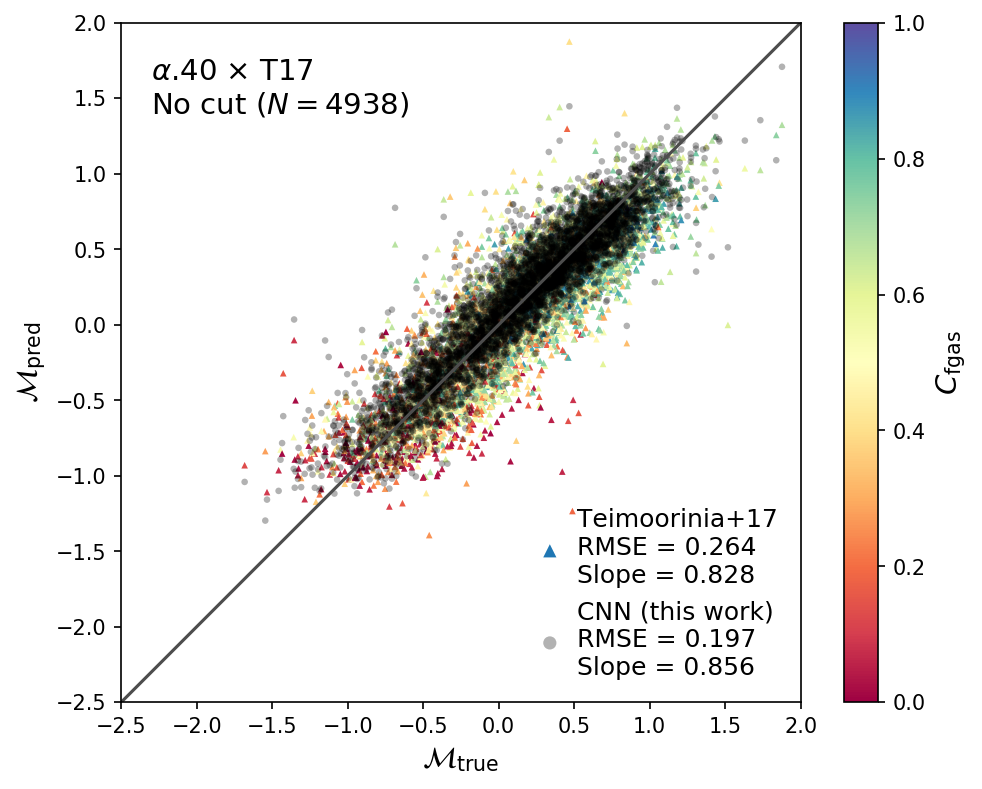

In [155]:
plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
mask = np.ones_like(a40_x_t17.fgas_true, dtype=bool)
N, rmse_a40_T17, slope_a40_T17, _, _ = summary_stats(a40_x_t17.fgas_t17, a40_x_t17.fgas_true, mask)
_, rmse_a40_CNN, slope_a40_CNN, _, _ = summary_stats(a40_x_t17.fgas_pred, a40_x_t17.fgas_true, mask)

sc = plt.scatter(a40_x_t17[mask].fgas_true, a40_x_t17[mask].fgas_t17, c=a40_x_t17[mask].Cfgas, edgecolors='none', cmap='Spectral', marker='^', s=10, vmin=0, vmax=1, label=f'Teimoorinia+17\nRMSE = {rmse_a40_T17:.3f}\nSlope = {slope_a40_T17:.3f}')
plt.scatter(a40_x_t17[mask].fgas_true, a40_x_t17[mask].fgas_pred, c='k', edgecolors='none', alpha=0.3, s=10, label=f'CNN (this work)\nRMSE = {rmse_a40_CNN:.3f}\nSlope = {slope_a40_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'$\alpha$.40 $\times$ T17' '\n' r'No cut' f' ($N={N}$)', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=2, handletextpad=0.1)

We can see that T17's color cut and removal of blended HI galaxies improves our RMSE.

# Compare xGASS test set with T17

In [9]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=2)
learn = Learner(nd_dls, model, opt_func=ranger, loss_func=LabelSmoothingCrossEntropy(eps=0.05), metrics=[accuracy, RocAuc()])
learn = learn.load('fastai2-xresnet34-non_detections_smoothed');

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


## Get xGASS PR probabilities

In [10]:
xg = pd.read_csv(f"{PATH}/data/xGASS_representative_sample.csv")

In [11]:
%%capture

xg_p_detection = np.array([to_np(learn.predict(f'{PATH}/images-xGASS/{fn}.jpg')[2][1]) for fn in xg.GASS])
xg['p_CNN'] = xg_p_detection

In [12]:
xg_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['GASS'], pref=f'{PATH}/images-xGASS/', suff='.jpg'),
    get_y=Pipeline([ColReader(['lgGF'], label_delim=None)]),
    splitter=FuncSplitter(lambda x: False),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

## Get xGASS predictions

In [13]:
a40 = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, a40, path=PATH, bs=64)

In [14]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)
learn = learn.load('fastai2-xresnet34-a40A-1');

In [15]:
xg_dls = ImageDataLoaders.from_dblock(xg_dblock, xg, path=PATH, bs=1)
xg_preds, xg_trues = learn.get_preds(dl=xg_dls.train)
xg_preds, xg_trues = to_np(xg_preds.view(-1)), to_np(xg_trues.view(-1))

In [16]:
xg['fgas_pred'] = xg_preds
xg['fgas_true'] = xg_trues

xg.sample(2)

,GASS,AGCnr,SDSS,PLATEID,MJD,FIBERID,RA,DEC,zSDSS,Dlum,...,group_id_B,NYU_id,env_code_B,Ngal_B,yang_shred_code,logMh_Mst_B,lvir_ratB,p_CNN,fgas_pred,fgas_true
812,9301,242429,J140316.98+042147.4,582,52045,271,210.82076,4.36317,0.04623,205.0,...,128406,489030,1,1,0,11.9822,-4.100103,0.054096,-0.547539,-1.486
732,26936,232632,J131525.21+152522.2,1773,53112,401,198.85506,15.42285,0.02655,116.0,...,343803,1833825,1,1,0,12.1765,-4.304866,0.748277,-0.985226,-1.812


In [19]:
print(' p,    N,   RMSE, slope,  std, offset')
for p in [0.0, 0.5, 0.80, 0.9]:
    print([p] + list(map(
                partial(np.round, decimals=3), 
                summary_stats(xg.fgas_pred, xg.fgas_true, xg.p_CNN > p)))
         )

 p,    N,   RMSE, slope,  std, offset
[0.0, 1179, 0.629, 0.471, 0.431, 0.459]
[0.5, 326, 0.331, 0.638, 0.302, 0.136]
[0.8, 217, 0.282, 0.686, 0.273, 0.075]
[0.9, 143, 0.252, 0.75, 0.243, 0.07]


Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

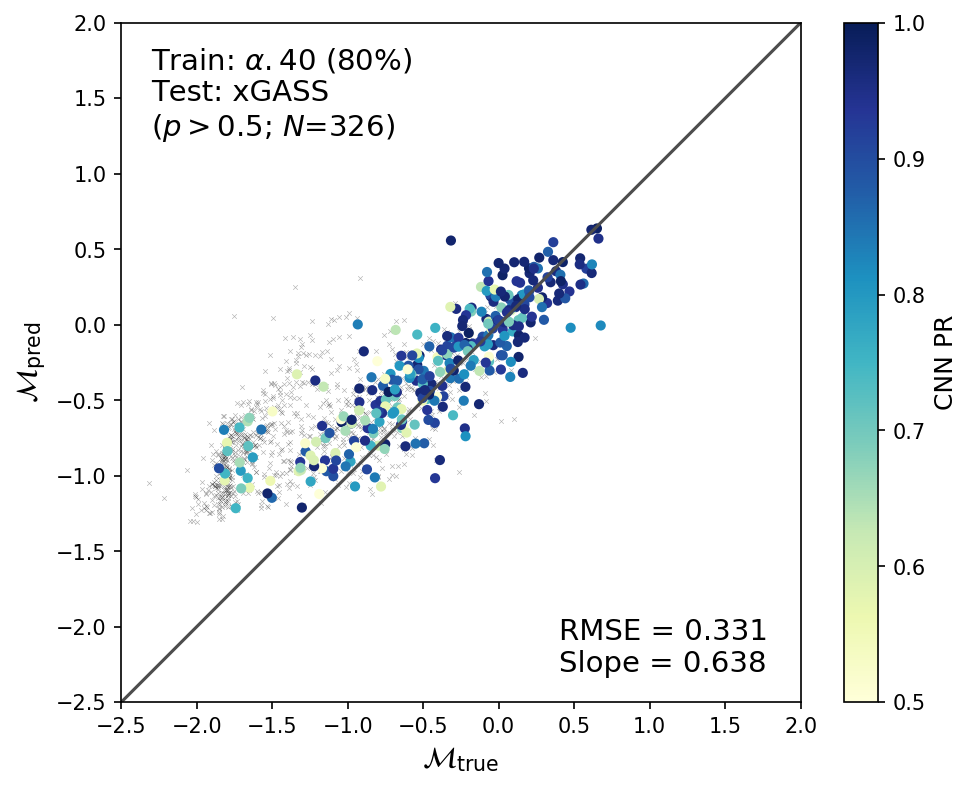

In [121]:
plt.figure(figsize=(7.5, 6), dpi=150)

p = 0.5
N, rmse_xg_CNN, slope_xg_CNN, _, _ = summary_stats(xg.fgas_pred, xg.fgas_true, xg.p_CNN > p)

plt.scatter(xg[xg.p_CNN <= p].fgas_true, xg[xg.p_CNN <= p].fgas_pred, marker='x', lw=0.3, c='k', alpha=0.3, s=5)
sc = plt.scatter(xg[xg.p_CNN > p].fgas_true, xg[xg.p_CNN > p].fgas_pred, c=xg[xg.p_CNN > p].p_CNN, s=15, vmin=0.5, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=12)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.25, r'Train: $\alpha.40$ (80%)' + f'\nTest: xGASS \n($p>{p:.1f}$; $N$={N})', fontsize=14)
plt.text(0.4, -2.3, f'RMSE = {rmse_xg_CNN:.3f}' + f'\nSlope = {slope_xg_CNN:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)


Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

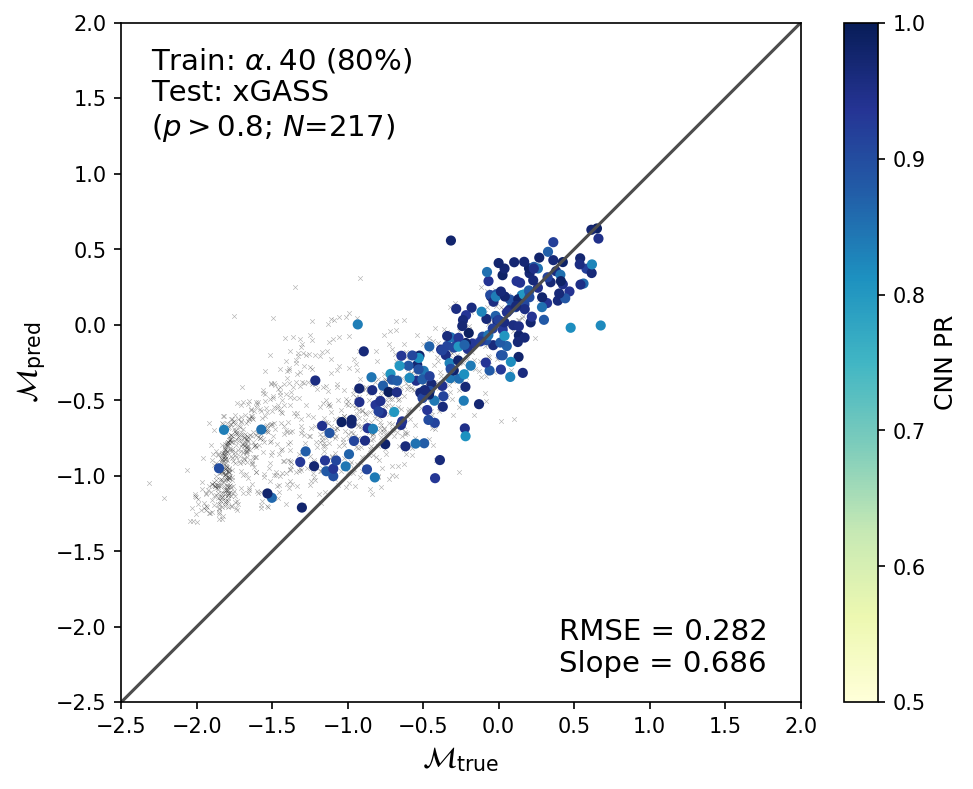

In [122]:
plt.figure(figsize=(7.5, 6), dpi=150)

p = 0.8
N, rmse_xg_CNN, slope_xg_CNN, _, _ = summary_stats(xg.fgas_pred, xg.fgas_true, xg.p_CNN > p)

plt.scatter(xg[xg.p_CNN <= p].fgas_true, xg[xg.p_CNN <= p].fgas_pred, marker='x', lw=0.3, c='k', alpha=0.3, s=5)
sc = plt.scatter(xg[xg.p_CNN > p].fgas_true, xg[xg.p_CNN > p].fgas_pred, c=xg[xg.p_CNN > p].p_CNN, s=15, vmin=0.5, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=12)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.25, r'Train: $\alpha.40$ (80%)' + f'\nTest: xGASS \n($p>{p:.1f}$; $N$={N})', fontsize=14)
plt.text(0.4, -2.3, f'RMSE = {rmse_xg_CNN:.3f}' + f'\nSlope = {slope_xg_CNN:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)


Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

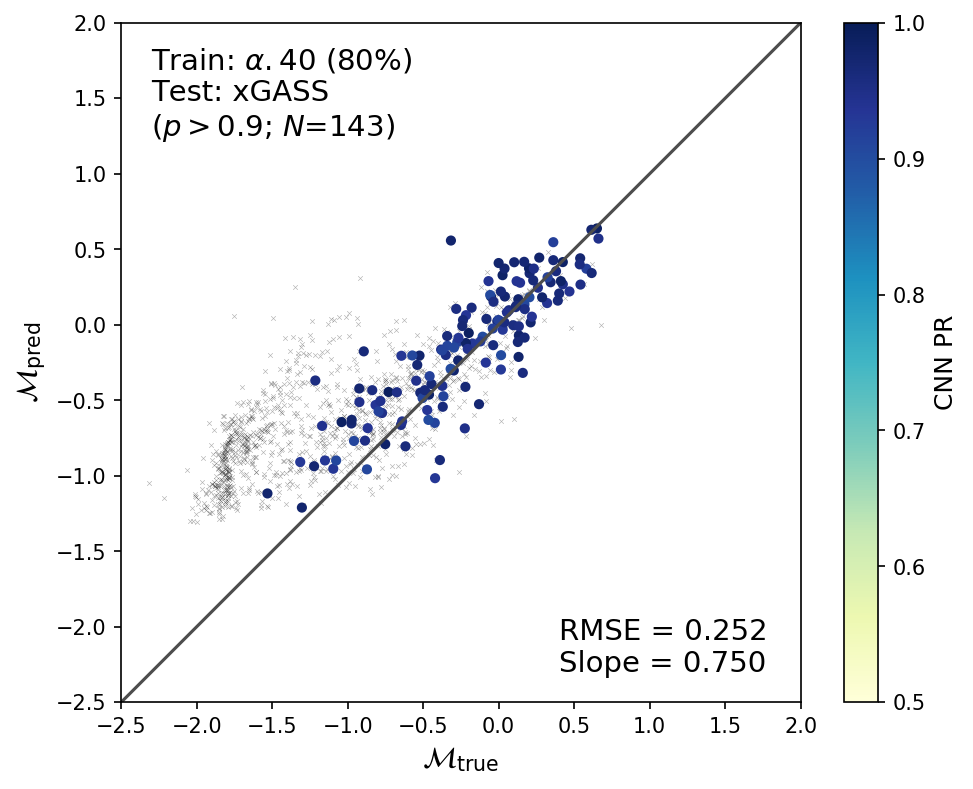

In [123]:
plt.figure(figsize=(7.5, 6), dpi=150)

p = 0.9
N, rmse_xg_CNN, slope_xg_CNN, _, _ = summary_stats(xg.fgas_pred, xg.fgas_true, xg.p_CNN > p)

plt.scatter(xg[xg.p_CNN <= p].fgas_true, xg[xg.p_CNN <= p].fgas_pred, marker='x', lw=0.3, c='k', alpha=0.3, s=5)
sc = plt.scatter(xg[xg.p_CNN > p].fgas_true, xg[xg.p_CNN > p].fgas_pred, c=xg[xg.p_CNN > p].p_CNN, s=15, vmin=0.5, vmax=1, cmap='YlGnBu')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=12)

plt.plot([-3, 3], [-3, 3], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.25, r'Train: $\alpha.40$ (80%)' + f'\nTest: xGASS \n($p>{p:.1f}$; $N$={N})', fontsize=14)
plt.text(0.4, -2.3, f'RMSE = {rmse_xg_CNN:.3f}' + f'\nSlope = {slope_xg_CNN:.3f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)


## Comparisons with T17

In [130]:
try:
    xg_coords = SkyCoord(xg.RA, xg.DEC, unit=u.deg)
    t17_coords = SkyCoord(t17.RAJ2000, t17.DEJ2000, unit=u.deg)
else:
    t17 = astropy.io.ascii.read(f'{PATH}/data/Teimoorinia+17.csv').to_pandas().loc[2:]

    t17 = t17.astype(
        {
            'SDSS': np.int64, 'RAJ2000': float, 'DEJ2000': float, 'z': float, 
            'logM*': float, 'logMHI/M*': float, 'Cfgas': float, 'PR': float,
            'sigmafitN': float, 'sigmafit': float, 'sigmafgas': float, 'Sloan': str
        }
    )
    
    xg_coords = SkyCoord(xg.RA, xg.DEC, unit=u.deg)
    t17_coords = SkyCoord(t17.RAJ2000, t17.DEJ2000, unit=u.deg)

In [132]:
# crossmatch again
cutoff = 1 / 3600 # deg
idx_t17, idx_xg, _, _ = xg_coords.search_around_sky(t17_coords, cutoff*u.deg)

In [133]:
t17_x_xg = t17.iloc[idx_t17]
xg_x_t17 = xg.iloc[idx_xg]

xg_x_t17.reset_index(drop=True, inplace=True)
t17_x_xg.reset_index(inplace=True)

t17_x_xg = t17_x_xg.rename({'z': 'z_t17', 'logMHI/M*': 'fgas_t17'}, axis=1)

xg_x_t17 = xg_x_t17.join(t17_x_xg, rsuffix='_T17')


In [134]:
# save xmatches
# xg_x_t17.to_csv(f'{PATH}/results/predictions/xGASSxT17-v2_trained-on-a40.csv', index='GASS')
xg_x_t17 = pd.read_csv(f'{PATH}/results/predictions/xGASSxT17-v2_trained-on-a40.csv', index_col='GASS')

### Use T17 Cfgas cuts

In [139]:
# Using T17 cut (Cfgas > 0.5), show my results first, then T17
print('      N,  RMSE, slope,  std, offset')

print(
    'CNN:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(xg_x_t17.fgas_pred, xg_x_t17.fgas_true, xg_x_t17.Cfgas > 0.5)))))
)

print(
    'T17:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(xg_x_t17.fgas_t17, xg_x_t17.fgas_true, xg_x_t17.Cfgas > 0.5)))))
)



      N,  RMSE, slope,  std, offset
CNN:  203 0.239 0.715 0.225 0.082
T17:  203 0.258 0.713 0.258 0.011


### No cuts (but still matches)

In [140]:
print('      N,  RMSE, slope,  std, offset')

print(
    'CNN:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(xg_x_t17.fgas_pred, xg_x_t17.fgas_true, xg_x_t17.Cfgas > -1)))))
)

print(
    'T17:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(xg_x_t17.fgas_t17, xg_x_t17.fgas_true, xg_x_t17.Cfgas > -1)))))
)


      N,  RMSE, slope,  std, offset
CNN:  1012 0.637 0.458 0.428 0.472
T17:  1012 0.675 0.41 0.479 0.476


### My cuts (p>0.5)

In [141]:
print('      N,  RMSE, slope,  std, offset')

print(
    'CNN:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(xg_x_t17.fgas_pred, xg_x_t17.fgas_true, xg_x_t17.p_CNN > 0.5)))))
)

print(
    'T17:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(xg_x_t17.fgas_t17, xg_x_t17.fgas_true, xg_x_t17.p_CNN > 0.5)))))
)


      N,  RMSE, slope,  std, offset
CNN:  262 0.327 0.624 0.297 0.138
T17:  262 0.383 0.58 0.365 0.118


### My cuts (p>0.8)

In [144]:
print('      N,  RMSE, slope,  std, offset')

print(
    'CNN:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(xg_x_t17.fgas_pred, xg_x_t17.fgas_true, xg_x_t17.p_CNN > 0.8)))))
)

print(
    'T17:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(xg_x_t17.fgas_t17, xg_x_t17.fgas_true, xg_x_t17.p_CNN > 0.8)))))
)


      N,  RMSE, slope,  std, offset
CNN:  168 0.265 0.669 0.257 0.069
T17:  168 0.319 0.657 0.318 0.028


### My cuts (p>0.9)

In [143]:
print('      N,  RMSE, slope,  std, offset')

print(
    'CNN:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(xg_x_t17.fgas_pred, xg_x_t17.fgas_true, xg_x_t17.p_CNN > 0.9)))))
)

print(
    'T17:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=3), 
        summary_stats(xg_x_t17.fgas_t17, xg_x_t17.fgas_true, xg_x_t17.p_CNN > 0.9)))))
)


      N,  RMSE, slope,  std, offset
CNN:  107 0.221 0.754 0.208 0.077
T17:  107 0.283 0.722 0.284 0.014


## Comparison plots

### with Cfgas mask

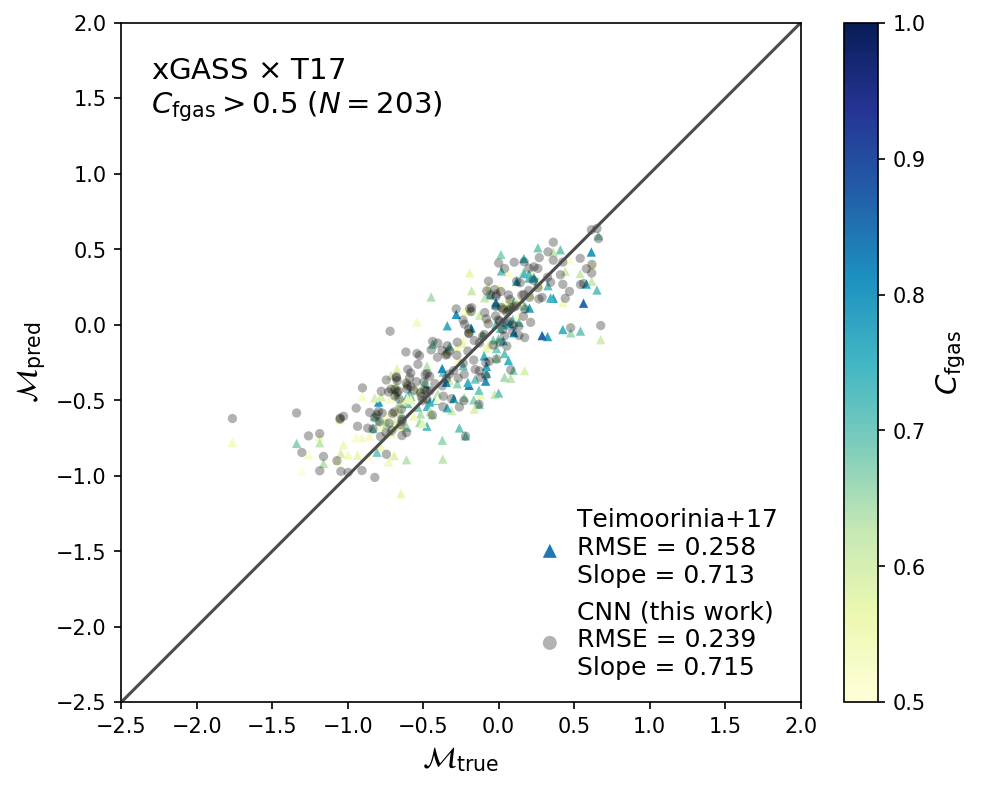

In [152]:
plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
mask = xg_x_t17.Cfgas > 0.5
N, rmse_xg_T17, slope_xg_T17, _, _ = summary_stats(xg_x_t17.fgas_t17, xg_x_t17.fgas_true, mask)
_, rmse_xg_CNN, slope_xg_CNN, _, _ = summary_stats(xg_x_t17.fgas_pred, xg_x_t17.fgas_true, mask)

sc = plt.scatter(xg_x_t17[mask].fgas_true, xg_x_t17[mask].fgas_t17, c=xg_x_t17[mask].Cfgas, edgecolors='none', cmap='YlGnBu', marker='^', s=20, vmin=0.5, vmax=1, label=f'Teimoorinia+17\nRMSE = {rmse_xg_T17:.3f}\nSlope = {slope_xg_T17:.3f}')
plt.scatter(xg_x_t17[mask].fgas_true, xg_x_t17[mask].fgas_pred, c='k', edgecolors='none', alpha=0.3, s=20, label=f'CNN (this work)\nRMSE = {rmse_xg_CNN:.3f}\nSlope = {slope_xg_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'xGASS $\times$ T17' '\n' r'$C_{\rm fgas} > 0.5$' f' ($N={N}$)', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=1.5, handletextpad=0.1)

### with CNN PR mask (p>0.5)

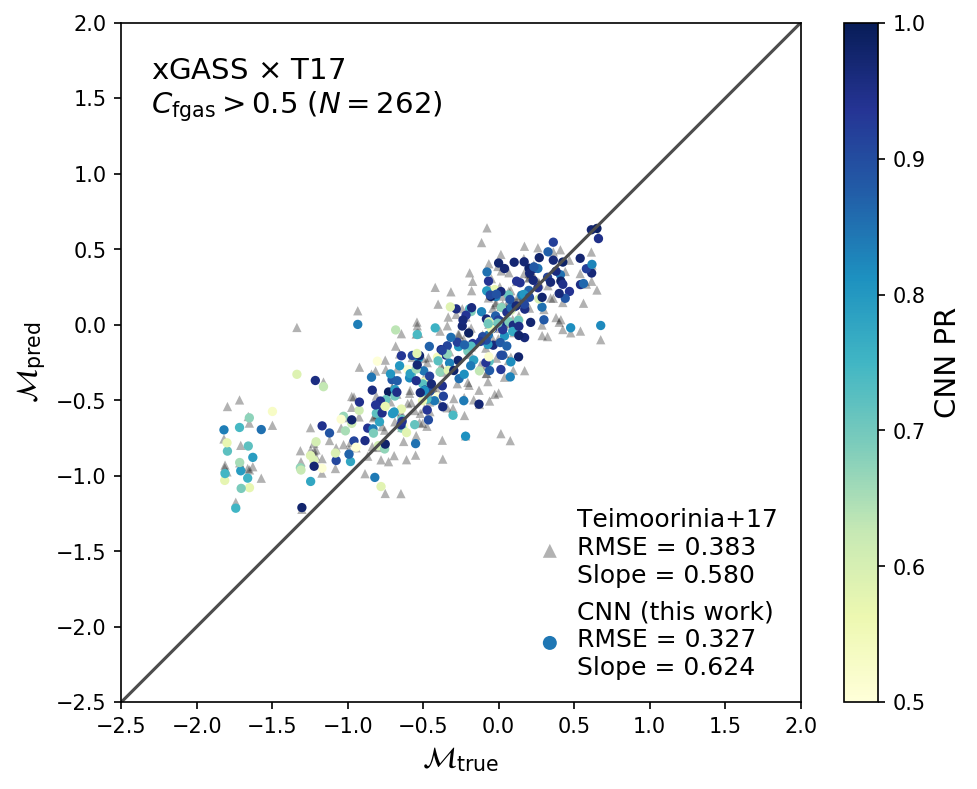

In [153]:
plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
mask = xg_x_t17.p_CNN > 0.5
N, rmse_xg_T17, slope_xg_T17, _, _ = summary_stats(xg_x_t17.fgas_t17, xg_x_t17.fgas_true, mask)
_, rmse_xg_CNN, slope_xg_CNN, _, _ = summary_stats(xg_x_t17.fgas_pred, xg_x_t17.fgas_true, mask)

plt.scatter(xg_x_t17[mask].fgas_true, xg_x_t17[mask].fgas_t17, c='k', edgecolors='none', alpha=0.3, marker='^', s=20, label=f'Teimoorinia+17\nRMSE = {rmse_xg_T17:.3f}\nSlope = {slope_xg_T17:.3f}')
sc = plt.scatter(xg_x_t17[mask].fgas_true, xg_x_t17[mask].fgas_pred, edgecolors='none', c=xg_x_t17[mask].p_CNN, cmap='YlGnBu', s=20, vmin=0.5, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_xg_CNN:.3f}\nSlope = {slope_xg_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'xGASS $\times$ T17' '\n' r'$C_{\rm fgas} > 0.5$' f' ($N={N}$)', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=1.5, handletextpad=0.1)

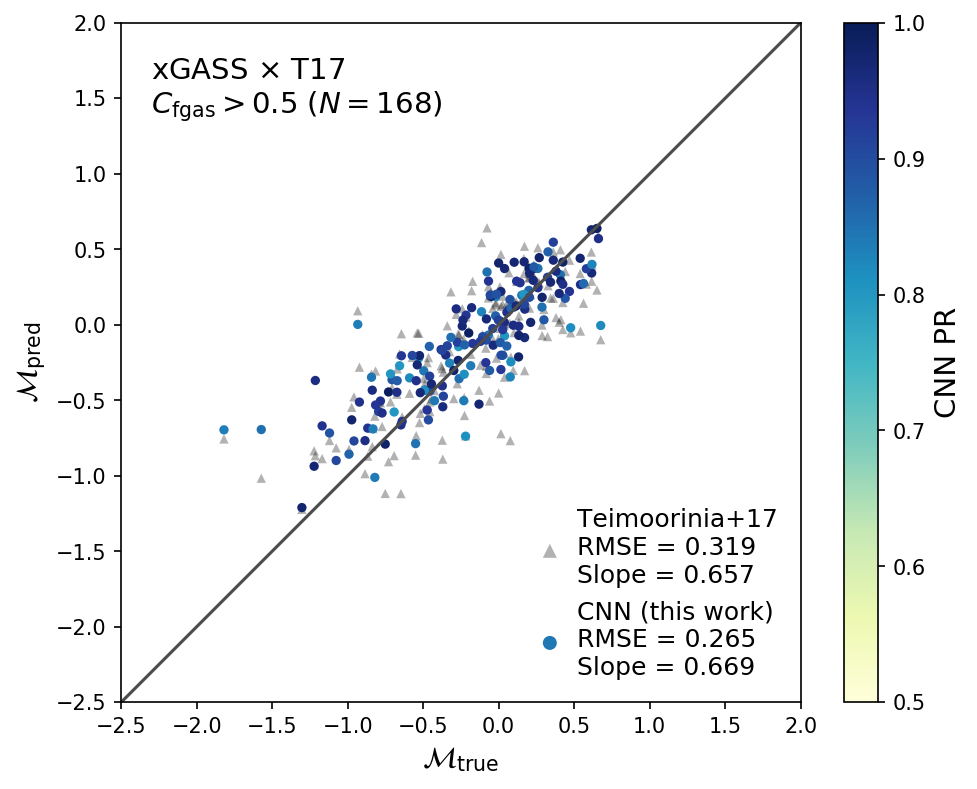

In [157]:
plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
mask = xg_x_t17.p_CNN > 0.8
N, rmse_xg_T17, slope_xg_T17, _, _ = summary_stats(xg_x_t17.fgas_t17, xg_x_t17.fgas_true, mask)
_, rmse_xg_CNN, slope_xg_CNN, _, _ = summary_stats(xg_x_t17.fgas_pred, xg_x_t17.fgas_true, mask)

plt.scatter(xg_x_t17[mask].fgas_true, xg_x_t17[mask].fgas_t17, c='k', edgecolors='none', alpha=0.3, marker='^', s=20, label=f'Teimoorinia+17\nRMSE = {rmse_xg_T17:.3f}\nSlope = {slope_xg_T17:.3f}')
sc = plt.scatter(xg_x_t17[mask].fgas_true, xg_x_t17[mask].fgas_pred, edgecolors='none', c=xg_x_t17[mask].p_CNN, cmap='YlGnBu', s=20, vmin=0.5, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_xg_CNN:.3f}\nSlope = {slope_xg_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'xGASS $\times$ T17' '\n' r'$C_{\rm fgas} > 0.5$' f' ($N={N}$)', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=1.5, handletextpad=0.1)

### CNN PR (p>0.9)

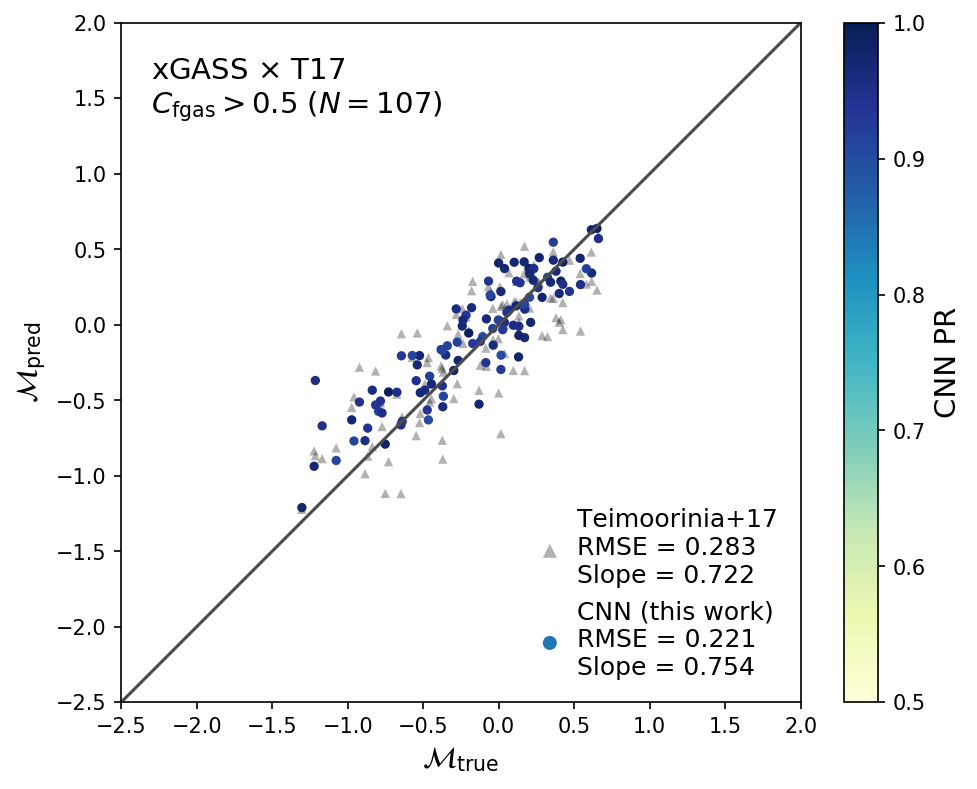

In [154]:
plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
mask = xg_x_t17.p_CNN > 0.9
N, rmse_xg_T17, slope_xg_T17, _, _ = summary_stats(xg_x_t17.fgas_t17, xg_x_t17.fgas_true, mask)
_, rmse_xg_CNN, slope_xg_CNN, _, _ = summary_stats(xg_x_t17.fgas_pred, xg_x_t17.fgas_true, mask)

plt.scatter(xg_x_t17[mask].fgas_true, xg_x_t17[mask].fgas_t17, c='k', edgecolors='none', alpha=0.3, marker='^', s=20, label=f'Teimoorinia+17\nRMSE = {rmse_xg_T17:.3f}\nSlope = {slope_xg_T17:.3f}')
sc = plt.scatter(xg_x_t17[mask].fgas_true, xg_x_t17[mask].fgas_pred, edgecolors='none', c=xg_x_t17[mask].p_CNN, cmap='YlGnBu', s=20, vmin=0.5, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_xg_CNN:.3f}\nSlope = {slope_xg_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'xGASS $\times$ T17' '\n' r'$C_{\rm fgas} > 0.5$' f' ($N={N}$)', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=1.5, handletextpad=0.1)